In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import os
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
import numpy as np

## 加载数据集

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### 加载标签

In [3]:
meta=unpickle("./cifar-100-python/meta")
meta.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

### 加载训练集

In [4]:
trainset=unpickle("./cifar-100-python/train")
trainset_x=trainset[b'data']
trainset_y=trainset[b'coarse_labels']

In [5]:
n_trainset=len(trainset_x)
n_trainset

50000

In [6]:
n_class=len(meta[b'coarse_label_names'])
n_class

20

### 加载测试集

In [7]:
testset=unpickle("./cifar-100-python/test")
testset_x=testset[b'data']
testset_y=testset[b'coarse_labels']

### 将数据集图像数据转成RGB图像

In [8]:
trainset_x=trainset_x.reshape(-1,3,32,32)
trainset_x=np.rollaxis(trainset_x, 1, 4)
trainset_x.shape

(50000, 32, 32, 3)

In [9]:
testset_x=testset_x.reshape(-1,3,32,32)
testset_x=np.rollaxis(testset_x, 1, 4)
testset_x.shape

(10000, 32, 32, 3)

## 数据增强处理函数

In [10]:
import shutil
from PIL import Image
import sys

current_num = 0

def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    return cl1

def Histograms_Equalization(img):
    equ = cv2.equalizeHist(img)
    return equ

def make_one_hot(data, num):
    return (np.arange(num)==data[:,None]).astype(np.int64)

## 处理训练集

In [11]:
from sklearn.utils import shuffle

new_X_train = []
new_y_train = []
for index in range(n_trainset):
    sys.stdout.write(" {} / {}\r".format(index, n_trainset))

    img_gray = cv2.cvtColor(trainset_x[index], cv2.COLOR_RGB2GRAY)

    new_X_train.append(img_gray.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    he_image = Histograms_Equalization(img_gray)
    new_X_train.append(he_image.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    clahe_img = CLAHE(img_gray)
    new_X_train.append(clahe_img.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    
print("All done!")
# all_xs, all_ys = shuffle(np.array(new_X_train), np.array(new_y_train), random_state=0)
all_xs = np.expand_dims(new_X_train, 3)
all_ys = make_one_hot(np.array(new_y_train), n_class)
train_xs, valid_xs, train_ys, valid_ys = train_test_split(
    all_xs, all_ys, test_size=0.2, random_state=0)

pickle.dump(all_xs, open('all_xs.p', 'wb'))
pickle.dump(all_ys, open('all_ys.p', 'wb'))

All done!50000


## 处理测试集

In [12]:
from sklearn.utils import shuffle

total_batch_size = 64

test_set = []
for j in range(len(testset_x)):
    img_gray = cv2.cvtColor(testset_x[j], cv2.COLOR_RGB2GRAY)
#     img_gray = Histograms_Equalization(img_gray)
    img_gray = np.expand_dims(img_gray, 2)
    img_gray = img_gray / 255.0
    test_set.append(img_gray)

test_set = np.array(test_set)
y_test = make_one_hot(np.array(testset_y), n_class)

def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

# TensorFlow 2.0实现

## Model Architecture

### keras basics implementation

In [13]:
from tensorflow import keras
import tensorflow as tf
import datetime
from tensorflow.python.ops import summary_ops_v2

### 第一种模型实现方法：

In [17]:
# 如果在之前的图像预处理部分没有使用img_gray = np.expand_dims(img_gray, 2)的话
# 网络一开始的InputLayer可以使用这句代码代替： keras.layers.Reshape(target_shape=[32, 32, 1], input_shape=(32, 32,)),

# 另外， InputLayer也可以省略，这样的话， 需要在Conv2D中指定输入的形状，网络前两层（InputLayer和Conv2D）可以用这句代码代替：
# keras.layers.Conv2D (kernel_size = (5, 5), filters = 100, activation='relu', input_shape=(32, 32, 1)),

# 注意， InputLayer并不是网络的第一层， 只是用来说明输入的尺寸
def get_model():
    model = keras.Sequential([
            keras.layers.InputLayer(input_shape=(32, 32, 1)),
            keras.layers.Conv2D (kernel_size = (5, 5), filters = 100, activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D (kernel_size = (3, 3), filters = 150, activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D (kernel_size = (3, 3), filters = 250, padding='same', activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(300, activation='relu'),
            keras.layers.Dense(n_class, activation='softmax')
        ])
    return model


In [325]:
# 此处代码是判断是否可以使用GPU训练
if tf.test.is_gpu_available():
    with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
        pass
    # 下面代码会使用一台机器上的所有GPU进行训练
#     strategy = tf.distribute.MirroredStrategy()
#     with strategy.scope():

In [18]:
# 如果在数据预处理的部分， 标签没有做one hot编码的话， 这里的损失函数可以使用sparse_categorical_crossentropy
model = get_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 100)       2600      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 150)       135150    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 150)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 250)         337750    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 250)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2250)              0

In [20]:
checkpoint_path = "training_models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True,
    # Save weights, every 1-epochs.
    period=1)

callbacks = [
    cp_callback,
    # Interrupt training if `val_loss` stops improving for over 2 epochs
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    # Write TensorBoard logs to `./logs` directory
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

W0610 11:34:34.541786 4427056576 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [21]:
# 开始训练
model.save_weights(checkpoint_path.format(epoch=0))
model.fit(train_xs, train_ys, epochs=1, batch_size=64, validation_data=(valid_xs, valid_ys), 
          callbacks=callbacks) # validation_split=0.2

W0610 11:34:46.725752 4427056576 deprecation.py:323] From /Applications/anaconda/envs/tf2beta/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 120000 samples, validate on 30000 samples
119936/120000 [============================>.] - ETA: 0s - loss: 2.6604 - accuracy: 0.1884
Epoch 00001: val_loss improved from inf to 2.41657, saving model to training_models/cp-0001.ckpt
120000/120000 [==============================] - 472s 4ms/sample - loss: 2.6603 - accuracy: 0.1884 - val_loss: 2.4166 - val_accuracy: 0.2627


#### 在测试集上的准确率

In [22]:
test_loss, test_acc = model.evaluate(test_set, y_test)

print('\nTest accuracy:', test_acc)

10000/10000 [==============================] - 11s 1ms/sample - loss: 2.4464 - accuracy: 0.2537

Test accuracy: 0.2537


#### 加载保存的参数继续训练

In [24]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

model = get_model()

model.load_weights(latest)

# The re-loaded model needs to be re-compiled.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_xs, train_ys, epochs=1, batch_size=64, validation_data=(valid_xs, valid_ys), 
          callbacks=callbacks) 

Train on 120000 samples, validate on 30000 samples
119936/120000 [============================>.] - ETA: 0s - loss: 2.3134 - accuracy: 0.2966
Epoch 00001: val_loss improved from 2.41657 to 2.21819, saving model to training_models/cp-0001.ckpt
120000/120000 [==============================] - 465s 4ms/sample - loss: 2.3134 - accuracy: 0.2966 - val_loss: 2.2182 - val_accuracy: 0.3215


#### Functional API

### 第二种模型实现方法：

In [25]:

inputs = keras.Input(shape=(32, 32, 1))  # Returns an input placeholder

# A layer instance is callable on a tensor, and returns a tensor.
x = keras.layers.Conv2D (kernel_size = (5, 5), filters = 100, activation='relu')(inputs)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D (kernel_size = (3, 3), filters = 150, activation='relu')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D (kernel_size = (3, 3), filters = 250, padding='same', activation='relu')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(300, activation='relu')(x)
predictions = keras.layers.Dense(n_class, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=predictions)

### 第三种模型实现方法：

In [26]:

class MyModel(keras.Model):

    def __init__(self):
        super(MyModel, self).__init__(name='my_model')

        # Define your layers here.
        self.layer1 = keras.layers.Conv2D (kernel_size = (5, 5), filters = 100, activation='relu')
        self.layer2 = keras.layers.MaxPool2D()
        self.layer3 = keras.layers.Conv2D (kernel_size = (3, 3), filters = 150, activation='relu')
        self.layer4 = keras.layers.MaxPool2D()
        self.layer5 = keras.layers.Conv2D (kernel_size = (3, 3), filters = 250, padding='same', activation='relu')
        self.layer6 = keras.layers.MaxPool2D()
        self.layer7 = keras.layers.Flatten()
        self.layer8 = keras.layers.Dense(512, activation='relu')
        self.layer9 = keras.layers.Dense(300, activation='relu')
        self.predictions = keras.layers.Dense(n_class, activation='softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        predictions = self.predictions(x)

        return predictions

model = MyModel()

In [28]:
# 准备数据集开始训练
val_dataset = tf.data.Dataset.from_tensor_slices((valid_xs, valid_ys))
val_dataset = val_dataset.batch(64).repeat()

dataset = tf.data.Dataset.from_tensor_slices((train_xs, train_ys))
dataset = dataset.shuffle(128).batch(64).repeat()  # .shuffle(len(train_xs))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Don't forget to specify `steps_per_epoch` when calling `fit` on a dataset.
model.fit(dataset, epochs=1, steps_per_epoch=(len(train_xs) // total_batch_size), 
          validation_data=val_dataset, validation_steps=(len(valid_xs) // total_batch_size), callbacks=callbacks)

1874/1875 [============================>.] - ETA: 0s - loss: 2.6562 - accuracy: 0.1898
Epoch 00001: val_loss did not improve from 2.21819
1875/1875 [==============================] - 465s 248ms/step - loss: 2.6560 - accuracy: 0.1899 - val_loss: 2.4274 - val_accuracy: 0.2590


#### 用来生成一个图像的输入数据

In [29]:
def generate_x(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img_gray = Histograms_Equalization(img)
    img_gray = np.expand_dims(img_gray, 2)
    img_gray = img_gray / 255.0
    img_gray = np.expand_dims(img_gray, 0)
    return img_gray

In [30]:
def showimg(index):
    img_gray = cv2.cvtColor(testset_x[index], cv2.COLOR_RGB2GRAY)
    plt.figure()
    plt.imshow(img_gray)

#### 加载模型参数做预测

14
14


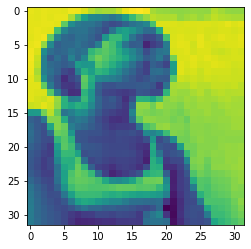

In [38]:
import random
latest = tf.train.latest_checkpoint(checkpoint_dir)

model = get_model()

model.load_weights(latest)

index = random.randint(0, len(testset_x))
showimg(index)

logits = model.predict(generate_x(testset_x[index]).astype('float32'))
print(testset_y[index])
print(np.argmax(logits[0])) # np.argmax(logits, 0)

### Functional implementation （Eager Execution Mode）

#### 学习目标y是one hot独热编码的实现

In [40]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = "./models"

class network(object):
    def __init__(self):
        # Hyperparameters
        self.model = keras.Sequential([
            keras.layers.InputLayer(input_shape=(32, 32, 1)),
            keras.layers.Conv2D (kernel_size = (5, 5), filters = 100, activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D (kernel_size = (3, 3), filters = 150, activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D (kernel_size = (3, 3), filters = 250, padding='same', activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(300, activation='relu'),
            keras.layers.Dense(n_class) 
        ])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

        if tf.io.gfile.exists(MODEL_DIR):
#             print('Removing existing model dir: {}'.format(MODEL_DIR))
#             tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)
        
        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
        self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')
        
        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)  

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    
#     @tf.function
    def compute_loss(self, logits, labels):
        # 如果目标y不是one hot独热编码的话使用sparse_categorical_crossentropy作为损失函数
        return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(labels, logits, from_logits=True))


    def compute_accuracy(self, logits, labels):
        # 注意， 代码中并没有用categorical_accuracy这个函数计算准确率，
        # 在后面我们用tf.keras.metrics.CategoricalAccuracy()计算准确率
        return tf.keras.metrics.categorical_accuracy(labels, logits)  
    
    @tf.function
    def train_step(self, images, labels):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        with tf.GradientTape() as tape:
            logits = self.model(images, training=True)
            loss = self.compute_loss(logits, labels)
            accuracy = self.compute_accuracy(logits, labels)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, accuracy, logits

    def training(self, train_dataset, test_dataset, epochs=1, log_freq=50):

        for i in range(epochs):
            train_start = time.time()
            with self.train_summary_writer.as_default():
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)  
#                 avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)  # 
                avg_accuracy = tf.keras.metrics.CategoricalAccuracy()
                
                # Datasets can be iterated over like any other Python iterable.
                for images, labels in train_dataset:
                    loss, accuracy, logits = self.train_step(images, labels)
                    avg_loss(loss)
#                     avg_accuracy(accuracy)
                    avg_accuracy.update_state(labels, logits)
                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        summary_ops_v2.scalar('accuracy', avg_accuracy.result(), step=self.optimizer.iterations)
                        
                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tLoss: {:0.6f} accuracy: {:0.2f}% ({} steps/sec)'.format(self.optimizer.iterations.numpy(), loss, (avg_accuracy.result() * 100), rate))
                        avg_loss.reset_states()
                        avg_accuracy.reset_states()
                        start = time.time()

            train_end = time.time()
            print('\nTrain time for epoch #{} ({} total steps): {}'.format(i + 1, self.optimizer.iterations.numpy(), train_end - train_start))
            with self.test_summary_writer.as_default():
                self.testing(test_dataset, self.optimizer.iterations)
            self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)
    
    def testing(self, test_dataset, step_num):
        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
#         avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)
        avg_accuracy = tf.keras.metrics.CategoricalAccuracy()

        for (images, labels) in test_dataset:
            logits = self.model(images, training=False)
            avg_loss(self.compute_loss(logits, labels))
#             avg_accuracy(self.compute_accuracy(logits, labels))
            avg_accuracy.update_state(labels, logits)
        print('Model test set loss: {:0.4f} accuracy: {:0.2f}%'.format(avg_loss.result(), avg_accuracy.result() * 100))
        summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        summary_ops_v2.scalar('accuracy', avg_accuracy.result(), step=step_num)
            
    def evaluating(self, test_dataset):
#         restored_model = tf.saved_model.restore(self.export_path)
#         y_predict = restored_model(x_test)
        avg_accuracy = tf.keras.metrics.CategoricalAccuracy()

        for (images, labels) in test_dataset:
            logits = self.model(images, training=False)
#             avg_accuracy(self.compute_accuracy(logits, labels))
            avg_accuracy.update_state(labels, logits)
        print('Model accuracy: {:0.2f}%'.format(avg_accuracy.result() * 100))

    def forward(self, xs):  
        predictions = self.model(xs)
        logits = tf.nn.softmax(predictions)

        return logits
    

In [41]:
val_dataset = tf.data.Dataset.from_tensor_slices((valid_xs.astype(np.float32), valid_ys))
val_dataset = val_dataset.batch(64)

dataset = tf.data.Dataset.from_tensor_slices((train_xs.astype(np.float32), train_ys))
dataset = dataset.batch(64)  # .shuffle(len(train_xs))
        

#### 训练网络

In [43]:
net = network()

net.training(dataset, val_dataset)

Step #50	Loss: 2.994897 accuracy: 5.66% (3.7079975940959518 steps/sec)
Step #100	Loss: 2.987721 accuracy: 5.03% (4.42650508891934 steps/sec)
Step #150	Loss: 2.956304 accuracy: 7.72% (4.354760733312643 steps/sec)
Step #200	Loss: 2.885026 accuracy: 10.19% (4.316026744254847 steps/sec)
Step #250	Loss: 2.781627 accuracy: 11.38% (4.284291078439908 steps/sec)
Step #300	Loss: 2.930704 accuracy: 12.25% (4.289365782341407 steps/sec)
Step #350	Loss: 2.797307 accuracy: 13.56% (4.282603577072803 steps/sec)
Step #400	Loss: 2.925358 accuracy: 13.19% (4.350552527838406 steps/sec)
Step #450	Loss: 2.844604 accuracy: 15.06% (4.359049298937128 steps/sec)
Step #500	Loss: 2.606718 accuracy: 15.94% (4.381845131242211 steps/sec)
Step #550	Loss: 2.796009 accuracy: 16.03% (4.343087943248135 steps/sec)
Step #600	Loss: 2.769403 accuracy: 15.94% (4.342142758187984 steps/sec)
Step #650	Loss: 2.582366 accuracy: 18.62% (4.383428330341064 steps/sec)
Step #700	Loss: 2.738522 accuracy: 18.19% (4.339460247103693 steps/s

#### 查看网络在测试集上的准确率

In [44]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_set.astype(np.float32), y_test))
test_dataset = test_dataset.batch(64)
net = network()
net.evaluating(test_dataset)

Model accuracy: 25.48%


## 非one hot版实现

此时的label是类别对应的数字，跟上面的实现区别只是损失函数和计算准确率函数不一样，其他都一样，损失函数使用：sparse_categorical_crossentropy，准确率使用sparse_categorical_accuracy计算

重新制作数据集，此时不再调用make_one_hot函数将label转换成one hot编码了，剩下的代码跟之前一样

In [45]:
import pickle
from sklearn.utils import shuffle

new_X_train = []
new_y_train = []
for index in range(n_trainset):
    sys.stdout.write(" {} / {}\r".format(index, n_trainset))

    img_gray = cv2.cvtColor(trainset_x[index], cv2.COLOR_RGB2GRAY)

    new_X_train.append(img_gray.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    he_image = Histograms_Equalization(img_gray)
    new_X_train.append(he_image.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    clahe_img = CLAHE(img_gray)
    new_X_train.append(clahe_img.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    

# all_xs, all_ys = shuffle(np.array(new_X_train), np.array(new_y_train), random_state=0)
all_xs = np.expand_dims(new_X_train, 3)
# all_ys = make_one_hot(all_ys, n_class)
train_xs, valid_xs, train_ys, valid_ys = train_test_split(
    all_xs, np.array(new_y_train), test_size=0.2, random_state=0)

# pickle.dump(all_xs, open('all_xs.p', 'wb'))
# pickle.dump(all_ys, open('all_ys.p', 'wb'))

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle

total_batch_size = 64

# # process valid dataset
# valid_set = []
# for j in range(len(X_valid)):
#     img_gray = cv2.cvtColor(X_valid[j], cv2.COLOR_RGB2GRAY)
# #     img_gray = Histograms_Equalization(img_gray)
#     img_gray = np.expand_dims(img_gray, 2)
#     img_gray = img_gray / 255.0
#     valid_set.append(img_gray)

# valid_set = np.array(valid_set)
# # y_valid = make_one_hot(y_valid, n_class)

# process test dataset
test_set = []
for j in range(len(testset_x)):
    img_gray = cv2.cvtColor(testset_x[j], cv2.COLOR_RGB2GRAY)
#     img_gray = Histograms_Equalization(img_gray)
    img_gray = np.expand_dims(img_gray, 2)
    img_gray = img_gray / 255.0
    test_set.append(img_gray)

test_set = np.array(test_set)
# y_test = make_one_hot(y_test, n_class)

print("All done!")

All done!50000


In [47]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = "./models"

class network(object):
    def __init__(self):
        # Hyperparameters
        self.model = keras.Sequential([
            keras.layers.InputLayer(input_shape=(32, 32, 1)),
            keras.layers.Conv2D (kernel_size = (5, 5), filters = 100, activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D (kernel_size = (3, 3), filters = 150, activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D (kernel_size = (3, 3), filters = 250, padding='same', activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(300, activation='relu'),
            keras.layers.Dense(n_class) 
        ])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

        if tf.io.gfile.exists(MODEL_DIR):
#             print('Removing existing model dir: {}'.format(MODEL_DIR))
#             tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)
        
        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
        self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')
        
        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)  

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    
#     @tf.function
    def compute_loss(self, logits, labels):
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True))


    def compute_accuracy(self, logits, labels):
        return tf.keras.metrics.sparse_categorical_accuracy(labels, logits)  # 
    
    @tf.function
    def train_step(self, images, labels):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        with tf.GradientTape() as tape:
            logits = self.model(images, training=True)
            loss = self.compute_loss(logits, labels)
            accuracy = self.compute_accuracy(logits, labels)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, accuracy, logits

    def training(self, train_dataset, test_dataset, epochs=1, log_freq=50):

        for i in range(epochs):
            train_start = time.time()
            with self.train_summary_writer.as_default():
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)  
                avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)  

                # Datasets can be iterated over like any other Python iterable.
                for images, labels in train_dataset:
                    loss, accuracy, logits = self.train_step(images, labels)
                    avg_loss(loss)
                    avg_accuracy(accuracy)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        summary_ops_v2.scalar('accuracy', avg_accuracy.result(), step=self.optimizer.iterations)
                        
                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tLoss: {:0.6f} accuracy: {:0.2f}% ({} steps/sec)'.format(self.optimizer.iterations.numpy(), loss, (avg_accuracy.result() * 100), rate))
                        avg_loss.reset_states()
                        avg_accuracy.reset_states()
                        start = time.time()

            train_end = time.time()
            print('\nTrain time for epoch #{} ({} total steps): {}'.format(i + 1, self.optimizer.iterations.numpy(), train_end - train_start))
            with self.test_summary_writer.as_default():
                self.testing(test_dataset, self.optimizer.iterations)
            self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)
    
    def testing(self, test_dataset, step_num):
        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)

        for (images, labels) in test_dataset:
            logits = self.model(images, training=False)
            avg_loss(self.compute_loss(logits, labels))
            avg_accuracy(self.compute_accuracy(logits, labels))

        print('Model test set loss: {:0.4f} accuracy: {:0.2f}%'.format(avg_loss.result(), avg_accuracy.result() * 100))
        summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        summary_ops_v2.scalar('accuracy', avg_accuracy.result(), step=step_num)
            
    def evaluating(self, test_dataset):
#         restored_model = tf.saved_model.restore(self.export_path)
#         y_predict = restored_model(x_test)
        avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)

        for (images, labels) in test_dataset:
            logits = self.model(images, training=False)
            avg_accuracy(self.compute_accuracy(logits, labels))

        print('Model accuracy: {:0.2f}%'.format(avg_accuracy.result() * 100))

    def forward(self, xs):  
        predictions = self.model(xs)
        logits = tf.nn.softmax(predictions)

        return logits
    

In [48]:
val_dataset = tf.data.Dataset.from_tensor_slices((valid_xs.astype(np.float32), valid_ys))
val_dataset = val_dataset.batch(64)

dataset = tf.data.Dataset.from_tensor_slices((train_xs.astype(np.float32), train_ys))
dataset = dataset.batch(64)  # .shuffle(len(train_xs))

In [49]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_set.astype(np.float32), testset_y))
test_dataset = test_dataset.batch(64)

### 训练网络，跟之前没什么区别

In [51]:
net = network()

# net.training(dataset, val_dataset)
net.training(val_dataset, test_dataset)

Step #50	Loss: 2.993327 accuracy: 5.62% (3.469405740158293 steps/sec)
Step #100	Loss: 2.989202 accuracy: 5.84% (3.961076227813938 steps/sec)
Step #150	Loss: 2.937308 accuracy: 8.16% (4.267125483361401 steps/sec)
Step #200	Loss: 2.862231 accuracy: 9.72% (4.376610849618697 steps/sec)
Step #250	Loss: 2.841537 accuracy: 10.59% (4.251312743469853 steps/sec)
Step #300	Loss: 2.734112 accuracy: 13.22% (4.229191104927479 steps/sec)
Step #350	Loss: 2.673699 accuracy: 13.16% (4.306034308495572 steps/sec)
Step #400	Loss: 2.807307 accuracy: 13.62% (4.368079935609545 steps/sec)
Step #450	Loss: 2.764752 accuracy: 14.50% (4.318316995649359 steps/sec)

Train time for epoch #1 (469 total steps): 113.01403522491455
Model test set loss: 2.7539 accuracy: 16.08%


### 测试集准确率

In [52]:
net.evaluating(test_dataset)

Model accuracy: 16.08%
